Load transcripts expression matrix

In [7]:
indir <- "/Users/hdelrisco/Documents/Rcode/"
expMatrix = read.table(file.path(indir, "expression_matrix.tsv"), row.names=1, header=TRUE)
cat("\nRead ", nrow(expMatrix), " transcripts expression data rows")
sums <- apply(expMatrix, 2, sum)
cat("\nSamples sum of read counts:")
cat("\n", formatC(sums, format="g", big.mark=","))
head(expMatrix)


Read  12908  transcripts expression data rows
Samples sum of read counts:
 6.054e+07 3.794e+07 4.704e+07 4.454e+07

,NSC,NSC.1,OLD,OLD.1
PB.1.1,7275.00,3602.00,3707.00,3485.00
PB.10.1,399.11,206.62,2092.22,2195.19
PB.10.2,336.89,342.38,1514.78,1250.81
PB.100.1,1017.00,762.00,1550.00,1431.00
PB.1000.1,9702.46,7516.41,22487.07,20060.06
PB.1000.2,11440.48,8961.81,30429.39,30558.65


An MA plot is an application of a Bland–Altman plot for visual representation of genomic data. The plot visualises the differences between measurements taken in two samples, by transforming the data onto M (log ratio) and A (mean average) scales, then plotting these values. Though originally applied in the context of two channel DNA microarray gene expression data, MA plots are also used to visualise high-throughput sequencing analysis.
The MA-plot is a plot of the distribution of the red/green intensity ratio ('M') plotted by the average intensity ('A'). M and A are defined by the following equations. In microarrays, the red (R) fluorescent dye, Cy5, is typically used for the case and the green (G), Cy3, for the control.

${\displaystyle M=\log _{2}(R/G)=\log _{2}(R)-\log _{2}(G)}$
<br/>
${\displaystyle A={\frac {1}{2}}\log _{2}(RG)={\frac {1}{2}}(\log _{2}(R)+\log _{2}(G))}$

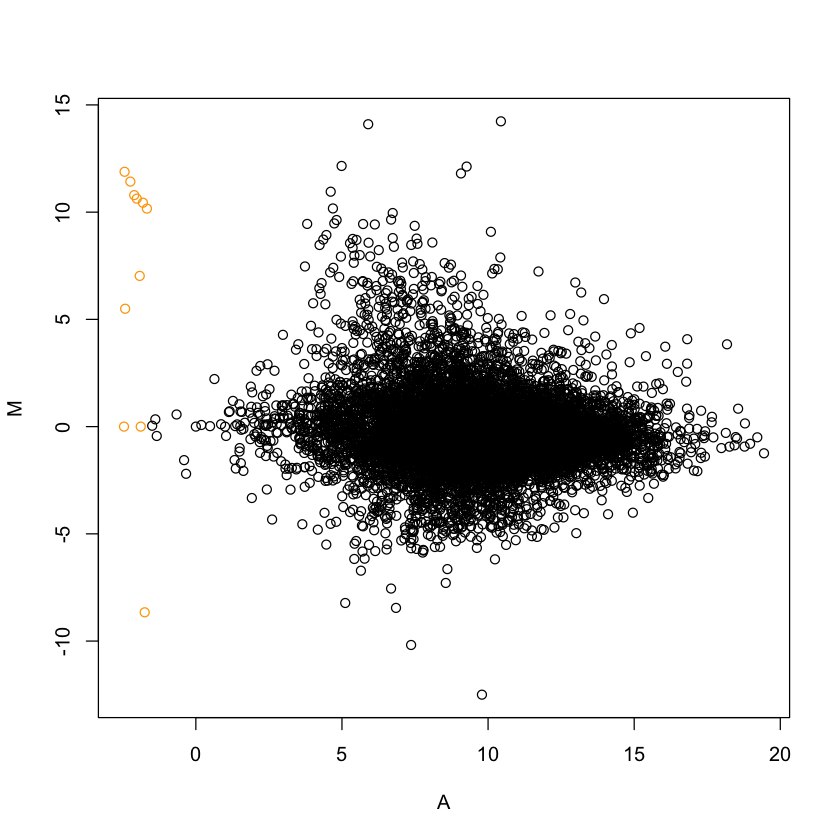

In [220]:
#library(affy)
# affy (ma.plot, mva.pairs), limma (plotMA), marray (maPlot), and edgeR(maPlot)

library(edgeR)
library(NOISeq)
# there are additional operations being done on the data
# which might explain why the plot is not identical to the manually generated one - not sure!
edgeR::maPlot(expMatrix[,1], expMatrix[, 3])


In [62]:
group <- factor(c(1,1,2,2))
y <- DGEList(counts=expMatrix, group=group)
cat("DGEList names: ", names(y))
cat("DGEList samples")
head(y$samples)
y <- calcNormFactors(y)
cat("DGEList samples after calcNormFactors")
head(y$samples)
ny <- cpm(y)
cat("EdgeR tmm/cpm normalized")
head(ny)
cat("NOISeq tmm normalized")
nn <- tmm(expMatrix)
head(nn)

design <- model.matrix(~group)
y <- estimateDisp(y, design)
cat("estimateDisp names: ", names(y))

DGEList names:  counts samplesDGEList samples

,group,lib.size,norm.factors
NSC,1,60542732,1
NSC.1,1,37941915,1
OLD,2,47042715,1
OLD.1,2,44538196,1


DGEList samples after calcNormFactors

,group,lib.size,norm.factors
NSC,1,60542732,1.0252867
NSC.1,1,37941915,1.0972805
OLD,2,47042715,0.9588224
OLD.1,2,44538196,0.9270408


EdgeR tmm/cpm normalized

,NSC,NSC.1,OLD,OLD.1
PB.1.1,117.199472,86.518066,82.18490,84.40561
PB.10.1,6.429619,4.962899,46.38492,53.16682
PB.10.2,5.427262,8.223780,33.58296,30.29423
PB.100.1,16.383761,18.302822,34.36380,34.65837
PB.1000.1,156.305593,180.540049,498.54266,485.84839
PB.1000.2,184.304909,215.257765,674.62541,740.12096


NOISeq tmm normalized

,NSC,NSC.1,OLD,OLD.1
PB.1.1,5568.8957,4111.0261,3905.130,4010.650
PB.10.1,305.5123,235.8190,2204.044,2526.295
PB.10.2,257.8839,390.7643,1595.741,1439.472
PB.100.1,778.4972,869.6840,1632.844,1646.841
PB.1000.1,7427.0774,8578.6113,23688.947,23085.761
PB.1000.2,8757.5038,10228.2718,32055.764,35167.876


estimateDisp names:  counts samples design common.dispersion trended.dispersion tagwise.dispersion AveLogCPM trend.method prior.df prior.n span

[1] 12898

NSC    NSC.1      OLD    OLD.1 
60542732 37941896 47038435 44532918

[1] -0.6085814  2.7542899  2.5328725  0.9720622  1.5767869  1.7754315

[1] 12897

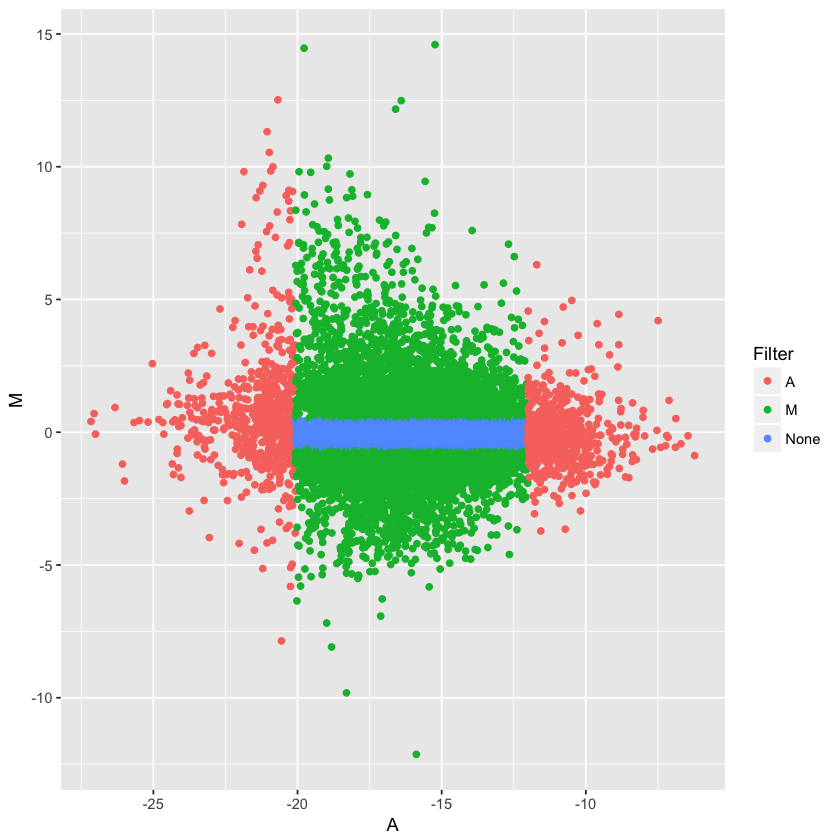

In [222]:
library(ggplot2)
options(stringsAsFactors = FALSE)
#maPlot(nn[,1], nn[, 3])
em <- expMatrix[expMatrix[, 1] > 0, ]
nrow(em)
#nk <- colSums(em) also works
nk <- apply(em, 2, sum)
head(nk)
m <- log2((em[,3]/nk[3])/(em[,1]/nk[1])) # swapping 1 and 3 just flips along the horizontal
head(m)
a <- 0.5 * log2((em[,3]/nk[3]) * (em[,1]/nk[1]))
filter <- rep("None", nrow(em))
df <- data.frame(a, m, filter)
df <- df[is.finite(rowSums(df[, 1:2])), ]
#df <- df[apply(df, 2, function(x) any(is.na(x) | is.infinite(x)))]
#df[apply(df, 2, function(x) any(is.infinite(x)))] - neither works, need to figure out how to negate!
nrow(df)
names(df) <- c("A", "M", "Filter")
trimM = 0.3
trimA = 0.05
dfcnt = nrow(df)
mcnt = as.integer(nrow(df) * trimM)
acnt = as.integer(nrow(df) * trimA)
df <- df[order(df$M), ]
df[1:mcnt, "Filter"] = "M"
df[(dfcnt - mcnt):dfcnt, "Filter"] = "M"
df <- df[order(df$A), ]
# would like to figure out a way to set the filter to "B" value if already set to M or to A otherwise
# but only n rows 1-acnt - need to figure out how to address the row name w/o converting to column!
#apply(df, 1, function(x) { if(x["row.names"] == 1 & x["Filter"] == "M") cat("hello")})
df[1:acnt, "Filter"] = "A"
df[(dfcnt - acnt):dfcnt, "Filter"] = "A"
ggplot(df, aes(A, M, color=Filter)) + geom_point()

# not sure how to setup for limma
#C <- as.matrix(df[, 1:2])
#head(C)
#library(limma)
#limma::plotMA(C)

In [223]:
cat("M Rows > 0: ", nrow(df[df$M > 0, ]), ", M Rows < 0: ", nrow(df[df$M < 0, ]))
cat("\nUnfiltered rows: ", nrow(df[df$Filter == "None", ]))
cat("\nA mean: ", mean(df[, 1]), ", M mean: ", mean(df[, 2]))
cat("\nTrimmed A mean: ", mean(df[df$Filter == "None", 1]), ", M mean: ", mean(df[df$Filter == "None", 2]))


M Rows > 0:  5902 , M Rows < 0:  6995
Unfiltered rows:  4677
A mean:  -15.8669 , M mean:  0.04855274
Trimmed A mean:  -15.52071 , M mean:  -0.1005394